In [1]:
from platform import python_version
print(python_version())

2.7.15


In [7]:
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter('ignore', ResourceWarning)
# warnings.simplefilter('ignore', UserWarning)

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
# from MVPA_functions import get_the_mask

# PyMVPA (kernel: 2.7)

In [2]:
from mvpa2.suite import *
from mvpa2.mappers.zscore import zscore
from mvpa2.mappers.fx import mean_group_sample
from mvpa2.measures import rsa, searchlight
from mvpa2.generators.partition import NFoldPartitioner
from mvpa2.datasets.mri import map2nifti

/home/aclexp/mambaforge/envs/pymvpa/lib/python2.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/home/aclexp/mambaforge/envs/pymvpa/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


### Define file paths and adopted version:

In [10]:
top_dir = os.path.join("/media", "data1", "pinwei", "SL_hippocampus")
mvpa_top = os.path.join(top_dir, "Combined_group", "derivatives", "PyMVPA")
data_top = os.path.join(mvpa_top, "masked_data")
clf_top = os.path.join(mvpa_top, "classification_out")
rdm_top = os.path.join(mvpa_top, "similarity_matrices")

In [155]:
## Quick setup:
# V = [4, 0, 0, 0, 0] # LSS.Betas 
V = [4, 1, 1, 1, 0] # Tstats_REML

afni_desc = ['runs', 'runs_v2', 'runs+behav', 'runs_v+', 'runs_v4'][V[0]]
reml = ['', '_REML'][V[1]]
lss = ['LSS.', ''][V[2]]
estm = ['Betas{:}'.format(reml), 'Tstats{:}'.format(reml)][V[3]]

print "### Data modeling version:", afni_desc
print '-->', lss+estm

### Data modeling version: runs_v4
--> Tstats_REML


### Regions of interest:

In [ ]:
# space = 'T1w'
# roi_list = [
#     'Pre_Central', 'Para_Central', 
# 	'Post_Central', 'Supra_Marginal', 'Sup_Pari', 'Inf_Pari', 'Pre_Cuneus', 
#     'Lingual', 'Peri_Calcarine', 'Cuneus', 'Lat_Occi', 'V1', 'V2', 'V3',
#     'Sup_Temp', 'Mid_Temp', 'Inf_Temp', 'Trans_Temp', 'Fusiform', 
#     'PHC', 'PRC', 'ERC', 'DG', 'CA3', 'CA1', 'Sub', 'HPC', 'MTL', 'HPC+MTL',
#     'Caudate', 'Putamen', 'Insula', 'Post_Cingulate', 'Isth_Cingulate', 'CBM'
# ]
# mask_types = [ 'a' for x in roi_list ]
# m_name_list = [ get_the_mask(space, m_type, roi)[0] for m_type, roi in zip(mask_types, roi_list) ]

# # for x, roi in enumerate(roi_list):
# #     print "[{:}] {:}".format(x, roi)

In [149]:
from MVPA_roiList import m_name_list
m_name_list.append("whole_brain")

### Select runs and load files:

In [156]:
# run_list = [ '{:02d}'.format(x) for x in range(1, 11) ] 
run_list = [ '{:02d}'.format(x) for x in range(2, 10) ] 
# run_list = ['01', '10']

In [157]:
info_DS = {}
data_DS = { run: {} for run in run_list }

for run in run_list:
    data_dir = os.path.join(data_top, 'ap-{:}'.format(afni_desc), 'run-{:}'.format(run), lss+estm)
    
    info_fn = "DS_raw_paths_union.pkl"
    with open(os.path.join(data_dir, info_fn), 'rb') as infile:
        info_DS[run] = pickle.load(infile)

    for m_name in m_name_list:
        data_fn = "union_masked_{:}.pkl".format(m_name)
        with open(os.path.join(data_dir, data_fn), 'rb') as infile:
            data_DS[run][m_name] = pickle.load(infile)

### Select a ROI, a participant, and concat data across runs:

In [197]:
DS = {}

sidx = 0
subj = info_DS[run][sidx].sid
print "# use {:}'s data".format(subj)

m_name = m_name_list[-1]
print "# ROI:", m_name

ds_list = [] 
for run in run_list:
    ds = data_DS[run][m_name][subj]
    ds_list.append(ds)
DS[subj] = vstack(ds_list, a=0)

ds = DS[subj]
print np.shape(ds.samples)

# use sub-02's data
# ROI: whole_brain
(96, 79507)


In [140]:
print SequenceStats(ds.sa.targets)

Sequence statistics for 586 entries from set ['A-1', 'A-2', 'A-3', 'B-1', 'B-2', 'B-3', 'C-1', 'C-2', 'C-3', 'D-1', 'D-2', 'D-3']
Counter-balance table for orders up to 2:
Targets/Order O1                                   |  O2                                   |
     A-1:     40 10  0  0  0  0  0  0  0  0  0  0  |  30 20  0  0  0  0  0  0  0  0  0  0  |
     A-2:      0 41 10  0  0  0  0  0  0  0  0  0  |   0 31 20  0  0  0  0  0  0  0  0  0  |
     A-3:      0  0 40 10  0  0  0  0  0  0  0  0  |   0  0 30 20  0  0  0  0  0  0  0  0  |
     B-1:      0  0  0 37 10  0  0  0  0  0  0  0  |   0  0  0 27 20  0  0  0  0  0  0  0  |
     B-2:      0  0  0  0 38 10  0  0  0  0  0  0  |   0  0  0  0 28 20  0  0  0  0  0  0  |
     B-3:      0  0  0  0  0 36 10  0  0  0  0  0  |   0  0  0  0  0 26 20  0  0  0  0  0  |
     C-1:      0  0  0  0  0  0 40 10  0  0  0  0  |   0  0  0  0  0  0 30 20  0  0  0  0  |
     C-2:      0  0  0  0  0  0  0 36 10  0  0  0  |   0  0  0  0  0  0  0 26 20  0 

# PyMVPA searchlight

### Classifier + searchlight

In [174]:
# raw_clf = LinearCSVMC()
# mapper = 
# clf = MappedClassifier(raw_clf, mapper) 
clf = LinearCSVMC()
CV = CrossValidation(clf, NFoldPartitioner(), 
                     errorfx=lambda p, t: np.mean(p == t), # to report accuracy 
                     enable_ca=['stats'])
sl_clf = sphere_searchlight(CV, radius=3, postproc=mean_sample())

### RSA + searchlight

In [ ]:
meas = ['euclidean', 'correlation'][1]
pdist = rsa.PDist(pairwise_metric=meas, # see scipy.spatial.distance.pdist for more metric options.
                  center_data=False,    # subtracting the column mean from each element.
                  square=True)          # if False, returns the flattened upper triangle.

sl_rsa = searchlight.sphere_searchlight(pdist, radius=3)

### Pre-process & go!

In [175]:
zscore(ds, chunks_attr='chunks')
# mgs_ds = mean_group_sample(['targets', 'chunks'])(ds)

In [176]:
import copy
remapper = copy.deepcopy(ds)

In [177]:
# remove invariant features (which might choke up some classifiers sometimes):
inv_mask = ds.samples.std(axis=0) != 0
sfs = StaticFeatureSelection(slicearg=inv_mask)
sfs.train(remapper)
data_m = remove_invariant_features(ds)
print np.mean(inv_mask) # % of data kept / 

0.8081804117876413


In [178]:
res = sl_clf(ds)
# res = sl_rsa(ds)

In [179]:
print res.summary()
print np.mean(res.samples) - (1.0 / len(data_m.UT))

Dataset: 1x79507@float64, <sa: cvfolds>, <fa: center_ids>, <a: mapper> stats: mean=0.0853194 std=0.0310901 var=0.000966594 min=0 max=0.291667

0.0019860672645175964


In [34]:
print res

<Dataset: 1x79507@float64, <sa: cvfolds>, <fa: center_ids>, <a: mapper>>


In [37]:
ds.a.imgaffine

array([[   2.32800007,   -0.        ,   -0.        ,  -81.46967316],
       [  -0.        ,    3.        ,   -0.        , -113.45179749],
       [   0.        ,    0.        ,    2.32800007,  -46.61785126],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

### Save to file:

In [191]:
# ts = res.a.mapper.reverse1(1 - res.samples[0])
ts = res.a.mapper.reverse1(res.samples[0])
print np.sum(ts)

6783.489583333333


In [192]:
nifti_file = "test_sphere_searchlight_{:}.nii.gz".format(subj)
# map2nifti(res).to_filename(nifti_file)
nb.Nifti1Image(ts, ds.a.imgaffine).to_filename(nifti_file)

# Plot with Nilearn 

In [188]:
# from nilearn.plotting import view_img, plot_anat, plot_epi, plot_glass_brain, plot_stat_map
from nilearn import image, plotting, masking

In [200]:
mask_file = info_DS[run][sidx].mask[m_name]
if m_name == "whole_brain":
    anat_dir = "/".join(mask_file.split("/")[:-1])
else:
    anat_dir = "/".join(mask_file.split("/")[:-2])
anat_file = os.path.join(anat_dir, "{:}_desc-preproc_T1w.nii.gz".format(subj))
stat_file = info_DS[run][sidx].data_path
# data_attr = pd.DataFrame(info_DS[run][sidx].data_attr)["targets"].to_list()
data_attr = data_DS[run][m_name][subj].sa.targets

print os.path.isfile(mask_file), "->", mask_file.split("/")[-1]
print os.path.isfile(anat_file), "->", anat_file.split("/")[-1]
print os.path.isfile(stat_file), "->", stat_file.split("/")[-1]
print "Stimuli:\n", data_attr

True -> mask_space-T1w_resam.nii.gz
True -> sub-02_desc-preproc_T1w.nii.gz
True -> allTstats_REML.nii
Stimuli:
['D-1' 'D-2' 'D-3' 'A-1' 'A-2' 'A-3' 'B-1' 'B-2' 'B-3' 'C-1' 'C-2' 'C-3']


In [203]:
# os.listdir(anat_dir)

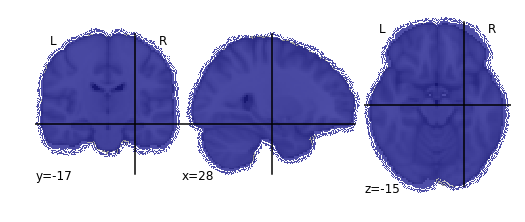

In [205]:
mni = "MNI152NLin2009cAsym"
if m_name == "whole_brain":
    roimask_bin = image.math_img(
        '(img > 0).astype(np.int32)', 
        img=os.path.join(anat_dir, "{:}_space-{:}_desc-preproc_T1w.nii.gz".format(subj, mni))
    )   
else:
    roimask_bin = image.math_img(
        '(img > 0).astype(np.int32)', 
        img=mask_file.replace("T1w", mni)
    )
plotting.plot_roi(
    roimask_bin, 
    cut_coords=(28, -17, -15)
)

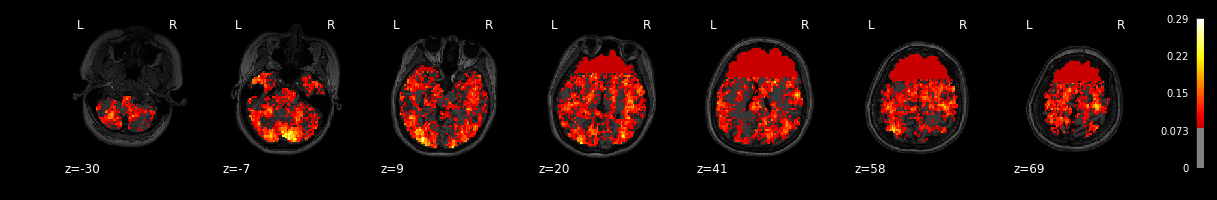

In [218]:
plotting.plot_stat_map(
    nifti_file, 
    bg_img=anat_path, 
    threshold=0.083,
    display_mode="z", 
    # cut_coords=5
)
### should use functional mask, !!! pending task !!!

In [49]:
# nipl.plot_glass_brain(None, # nifti_file, 
#                       bg_img=anat_path, 
#                       display_mode='lzry')
# display.add_contours(nifti_file)

In [ ]:
# from nltools.data import Brain_Data
# amygdala_mask = Brain_Data('https://neurovault.org/media/images/1290/FSL_BAmyg_thr0.nii.gz').to_nifti()

# view_img(amygdala_mask, data)

# Nilearn Decoding (kernel: 2.7 or 3.10)

In [ ]:
deri_dir = "/media/data1/pinwei/SL_hippocampus/Nifti/derivatives"
mask_path = deri_dir + "/fmriprep_fmap_RL/sub-02/anat/ROImasks/roimask_space-T1w_HPC_resam.nii.gz"
bold_path = deri_dir + "/fmriprep_fmap_RL/sub-02/func/T1_space/sub-02_task-vsl_run-02_space-T1w_desc-preproc_bold.nii.gz"
stats_path = deri_dir + "/afni_out/SS_results_runs/sub-02_r09.results/LSS.all-stim_allBetas.nii"
# masked_stats = ds.samples
# # attr_file = deri_dir + "/afni_out/SS_results_runs/sub-02_r09.results/LSS.all-stim_attrs.txt"
# attrs = ds.sa.targets

In [ ]:
attrs = np.array([
    'D-1', 'D-1', 'D-1', 'D-1', 'D-1', 'D-1', 'D-2', 'D-2', 'D-2', 
    'D-2', 'D-2', 'D-2', 'D-3', 'D-3', 'D-3', 'D-3', 'D-3', 'A-1', 
    'A-1', 'A-1', 'A-1', 'A-1', 'A-1', 'A-2', 'A-2', 'A-2', 'A-2', 
    'A-2', 'A-2', 'A-3', 'A-3', 'A-3', 'A-3', 'A-3', 'B-1', 'B-1', 
    'B-1', 'B-1', 'B-1', 'B-2', 'B-2', 'B-2', 'B-2', 'B-2', 'B-2', 
    'B-3', 'B-3', 'B-3', 'B-3', 'B-3', 'C-1', 'C-1', 'C-1', 'C-1', 
    'C-1', 'C-1', 'C-2', 'C-2', 'C-2', 'C-3', 'C-3', 'C-3', 'C-3', 
    'C-3', 'C-3'])

In [ ]:
import nibabel as nib

bold_file = nib.load(bold_path)
print(bold_file.shape)

stats_file = nib.load(stats_path)
print(stats_file.shape)

### nilearn.decoding.SearchLight

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)

import nilearn.decoding
searchlight = nilearn.decoding.SearchLight(
    mask_path,
    radius=5.6,
    n_jobs=3,
    verbose=1,
    cv=cv,
)
searchlight.fit(stats_file, attrs)

In [ ]:
from nilearn.maskers import NiftiMasker
# https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMasker.html#nilearn-maskers-niftimasker

nifti_masker = NiftiMasker(
    mask_img=mask_path,
    standardize="zscore_sample", # For decoding, standardizing is often very important
    memory="nilearn_cache",
)
bold_masked = nifti_masker.fit_transform(bold_file)
stats_masked = nifti_masker.fit_transform(stats_file)

In [ ]:
# from sklearn.feature_selection import f_classif

# _, p_values = f_classif(stats_file, attrs)
# p_values = -np.log10(p_values)
# p_values[p_values > 10] = 10
# p_unmasked = get_data(nifti_masker.inverse_transform(p_values))

In [ ]:
from nilearn import image

bold_mean = image.mean_img(bold_file)

In [ ]:
from nilearn.image import new_img_like
from nilearn.plotting import plot_img, plot_stat_map, show

searchlight_img = new_img_like(bold_mean, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(
    searchlight_img,
    bg_img=bold_mean,
    title="Searchlight",
    display_mode="z",
    cut_coords=[-9],
    vmin=0.42,
    cmap="hot",
    threshold=0.2,
    black_bg=True,
)

# # F_score results
# p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
# f_score_img = new_img_like(mean_fmri, p_ma)
# plot_stat_map(
#     f_score_img,
#     mean_fmri,
#     title="F-scores",
#     display_mode="z",
#     cut_coords=[-9],
#     colorbar=False,
# )

show()

### nilearn.decoding.Decoder

In [ ]:
decoder = nilearn.decoding.Decoder(
    estimator="svc",
    mask=mask_file,
    standardize=False,
    screening_percentile=5,
    cv=LeaveOneGroupOut()
)
decoder.fit(masked_stats, attrs)

In [ ]:
# Return the corresponding mean prediction accuracy compared to chance

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1.0 / len(np.unique(conditions))
print(
    "Classification accuracy: {:.4f} / Chance level: {}".format(
        classification_accuracy, chance_level
    )
)

# Is's GL Python code! (run in MRIcroGL)